In [1]:
import torch
from torch import nn
from torch.optim import *
from torchvision.datasets import MNIST
from torchvision.transforms import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm

In [2]:
torch.random.manual_seed(1)
np.random.seed(1)

In [3]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = './datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

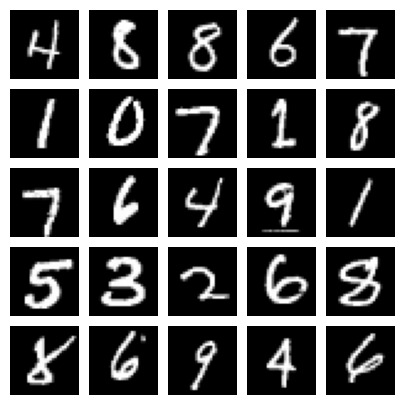

In [4]:
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim1=256, hidden_dim2=128, latent_dim=16, device=device):
        super(VAE, self).__init__()
        self.ld = latent_dim
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.LeakyReLU(0.2)
        )

        # latent mean and variance
        self.mean_layer = nn.Linear(hidden_dim2, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim2, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim1, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.mean_layer(x)
        logvar = self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, std_dev):
        epsilon = torch.randn_like(std_dev).to(device)
        z = mean + std_dev*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

    def generate(self, inp_mean, inp_std_dev, num_samples = 1):
        z = torch.normal(inp_mean, inp_std_dev, size=(num_samples, self.ld)).to(device)
        x_hat = self.decode(z)
        x_hat = x_hat.detach().cpu().reshape(num_samples, 28, 28)
        return x_hat


In [6]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=15, gamma=0.5)

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [8]:
from google.colab import drive

In [9]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
def train(model, optimizer, scheduler, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        with tqdm(train_loader, desc='train') as progress_bar:
          for batch_idx, (x, _) in enumerate(progress_bar):
              x = x.view(batch_size, x_dim).to(device)

              optimizer.zero_grad()

              x_hat, mean, log_var = model.forward(x)
              loss = loss_function(x, x_hat, mean, log_var)

              overall_loss += loss.item()

              loss.backward()
              optimizer.step()

        scheduler.step()
        print("\tEpoch", epoch + 1, "lr", optimizer.param_groups[0]['lr'], "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))

        # Save the model checkpoint after each epoch
        path = '/content/drive/MyDrive/SAiDL_CV/vae_model.pth'
        torch.save(model.state_dict(), path)

    return overall_loss

In [11]:
train(model, optimizer, scheduler, epochs=50, device=device)

train: 100%|██████████| 600/600 [00:13<00:00, 45.85it/s]


	Epoch 1 lr 0.001 	Average Loss:  174.8938753065004


train: 100%|██████████| 600/600 [00:13<00:00, 45.27it/s]


	Epoch 2 lr 0.001 	Average Loss:  127.863556594976


train: 100%|██████████| 600/600 [00:08<00:00, 70.36it/s]


	Epoch 3 lr 0.001 	Average Loss:  118.84658343332637


train: 100%|██████████| 600/600 [00:08<00:00, 70.90it/s]


	Epoch 4 lr 0.001 	Average Loss:  114.67943618596098


train: 100%|██████████| 600/600 [00:08<00:00, 67.04it/s]


	Epoch 5 lr 0.001 	Average Loss:  112.0551082696421


train: 100%|██████████| 600/600 [00:08<00:00, 69.60it/s]


	Epoch 6 lr 0.001 	Average Loss:  110.35695372821891


train: 100%|██████████| 600/600 [00:08<00:00, 71.12it/s]


	Epoch 7 lr 0.001 	Average Loss:  109.12249832076898


train: 100%|██████████| 600/600 [00:08<00:00, 66.90it/s]


	Epoch 8 lr 0.001 	Average Loss:  108.06384113496452


train: 100%|██████████| 600/600 [00:09<00:00, 62.30it/s]


	Epoch 9 lr 0.001 	Average Loss:  107.27924638394721


train: 100%|██████████| 600/600 [00:08<00:00, 69.99it/s]


	Epoch 10 lr 0.001 	Average Loss:  106.61138440369366


train: 100%|██████████| 600/600 [00:09<00:00, 66.10it/s]


	Epoch 11 lr 0.001 	Average Loss:  106.04016710794032


train: 100%|██████████| 600/600 [00:10<00:00, 59.14it/s]


	Epoch 12 lr 0.001 	Average Loss:  105.52444696238523


train: 100%|██████████| 600/600 [00:13<00:00, 45.23it/s]


	Epoch 13 lr 0.001 	Average Loss:  105.10328845602045


train: 100%|██████████| 600/600 [00:15<00:00, 39.68it/s]


	Epoch 14 lr 0.001 	Average Loss:  104.76011462789545


train: 100%|██████████| 600/600 [00:10<00:00, 57.36it/s]


	Epoch 15 lr 0.0005 	Average Loss:  104.376236647668


train: 100%|██████████| 600/600 [00:08<00:00, 73.11it/s]


	Epoch 16 lr 0.0005 	Average Loss:  103.04066760029737


train: 100%|██████████| 600/600 [00:11<00:00, 50.86it/s]


	Epoch 17 lr 0.0005 	Average Loss:  102.80847939925918


train: 100%|██████████| 600/600 [00:09<00:00, 62.41it/s]


	Epoch 18 lr 0.0005 	Average Loss:  102.68026368817821


train: 100%|██████████| 600/600 [00:08<00:00, 67.13it/s]


	Epoch 19 lr 0.0005 	Average Loss:  102.55500024454821


train: 100%|██████████| 600/600 [00:10<00:00, 60.00it/s]


	Epoch 20 lr 0.0005 	Average Loss:  102.38569888616443


train: 100%|██████████| 600/600 [00:12<00:00, 49.14it/s]


	Epoch 21 lr 0.0005 	Average Loss:  102.24942703985809


train: 100%|██████████| 600/600 [00:09<00:00, 64.18it/s]


	Epoch 22 lr 0.0005 	Average Loss:  102.07865377843281


train: 100%|██████████| 600/600 [00:09<00:00, 66.56it/s]


	Epoch 23 lr 0.0005 	Average Loss:  101.96797385290589


train: 100%|██████████| 600/600 [00:09<00:00, 61.76it/s]


	Epoch 24 lr 0.0005 	Average Loss:  101.84719731453464


train: 100%|██████████| 600/600 [00:09<00:00, 65.55it/s]


	Epoch 25 lr 0.0005 	Average Loss:  101.74505857744678


train: 100%|██████████| 600/600 [00:08<00:00, 67.75it/s]


	Epoch 26 lr 0.0005 	Average Loss:  101.63862673140129


train: 100%|██████████| 600/600 [00:08<00:00, 71.43it/s]


	Epoch 27 lr 0.0005 	Average Loss:  101.5443173518364


train: 100%|██████████| 600/600 [00:08<00:00, 70.21it/s]


	Epoch 28 lr 0.0005 	Average Loss:  101.45296054948352


train: 100%|██████████| 600/600 [00:09<00:00, 62.34it/s]


	Epoch 29 lr 0.0005 	Average Loss:  101.36524058652442


train: 100%|██████████| 600/600 [00:12<00:00, 48.75it/s]


	Epoch 30 lr 0.00025 	Average Loss:  101.26769695912458


train: 100%|██████████| 600/600 [00:12<00:00, 46.44it/s]


	Epoch 31 lr 0.00025 	Average Loss:  100.57977393963898


train: 100%|██████████| 600/600 [00:09<00:00, 61.65it/s]


	Epoch 32 lr 0.00025 	Average Loss:  100.50276509025458


train: 100%|██████████| 600/600 [00:09<00:00, 64.98it/s]


	Epoch 33 lr 0.00025 	Average Loss:  100.46458117044031


train: 100%|██████████| 600/600 [00:10<00:00, 58.39it/s]


	Epoch 34 lr 0.00025 	Average Loss:  100.40935789792884


train: 100%|██████████| 600/600 [00:09<00:00, 65.33it/s]


	Epoch 35 lr 0.00025 	Average Loss:  100.34991597323665


train: 100%|██████████| 600/600 [00:07<00:00, 75.58it/s]


	Epoch 36 lr 0.00025 	Average Loss:  100.34334620200335


train: 100%|██████████| 600/600 [00:09<00:00, 62.98it/s]


	Epoch 37 lr 0.00025 	Average Loss:  100.2519949264399


train: 100%|██████████| 600/600 [00:09<00:00, 64.89it/s]


	Epoch 38 lr 0.00025 	Average Loss:  100.24109908115088


train: 100%|██████████| 600/600 [00:07<00:00, 75.40it/s]


	Epoch 39 lr 0.00025 	Average Loss:  100.16411899063543


train: 100%|██████████| 600/600 [00:08<00:00, 67.43it/s]


	Epoch 40 lr 0.00025 	Average Loss:  100.16306802026816


train: 100%|██████████| 600/600 [00:09<00:00, 65.23it/s]


	Epoch 41 lr 0.00025 	Average Loss:  100.09073714980697


train: 100%|██████████| 600/600 [00:08<00:00, 73.62it/s]


	Epoch 42 lr 0.00025 	Average Loss:  100.08519369848185


train: 100%|██████████| 600/600 [00:17<00:00, 35.10it/s]


	Epoch 43 lr 0.00025 	Average Loss:  100.04200193682179


train: 100%|██████████| 600/600 [00:08<00:00, 70.24it/s]


	Epoch 44 lr 0.00025 	Average Loss:  100.00667482914233


train: 100%|██████████| 600/600 [00:08<00:00, 67.13it/s]


	Epoch 45 lr 0.000125 	Average Loss:  99.94661649624373


train: 100%|██████████| 600/600 [00:08<00:00, 67.64it/s]


	Epoch 46 lr 0.000125 	Average Loss:  99.62566508960246


train: 100%|██████████| 600/600 [00:07<00:00, 75.57it/s]


	Epoch 47 lr 0.000125 	Average Loss:  99.54575389320743


train: 100%|██████████| 600/600 [00:08<00:00, 66.90it/s]


	Epoch 48 lr 0.000125 	Average Loss:  99.5645881808222


train: 100%|██████████| 600/600 [00:08<00:00, 66.96it/s]


	Epoch 49 lr 0.000125 	Average Loss:  99.54590466532763


train: 100%|██████████| 600/600 [00:07<00:00, 75.48it/s]

	Epoch 50 lr 0.000125 	Average Loss:  99.53853103153693


5962358.0087890625

In [12]:
# Load the saved model
load_path = '/content/drive/MyDrive/SAiDL_CV/vae_model.pth'
loaded_model = VAE().to(device)
loaded_model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu')))
print(f"Model loaded from {load_path}")

Model loaded from /content/drive/MyDrive/SAiDL_CV/vae_model.pth


In [13]:
num_images_gen = 50
digit_normal = loaded_model.generate(0, 1, num_images_gen)
digit_gaussian = loaded_model.generate(1, 2, num_images_gen)

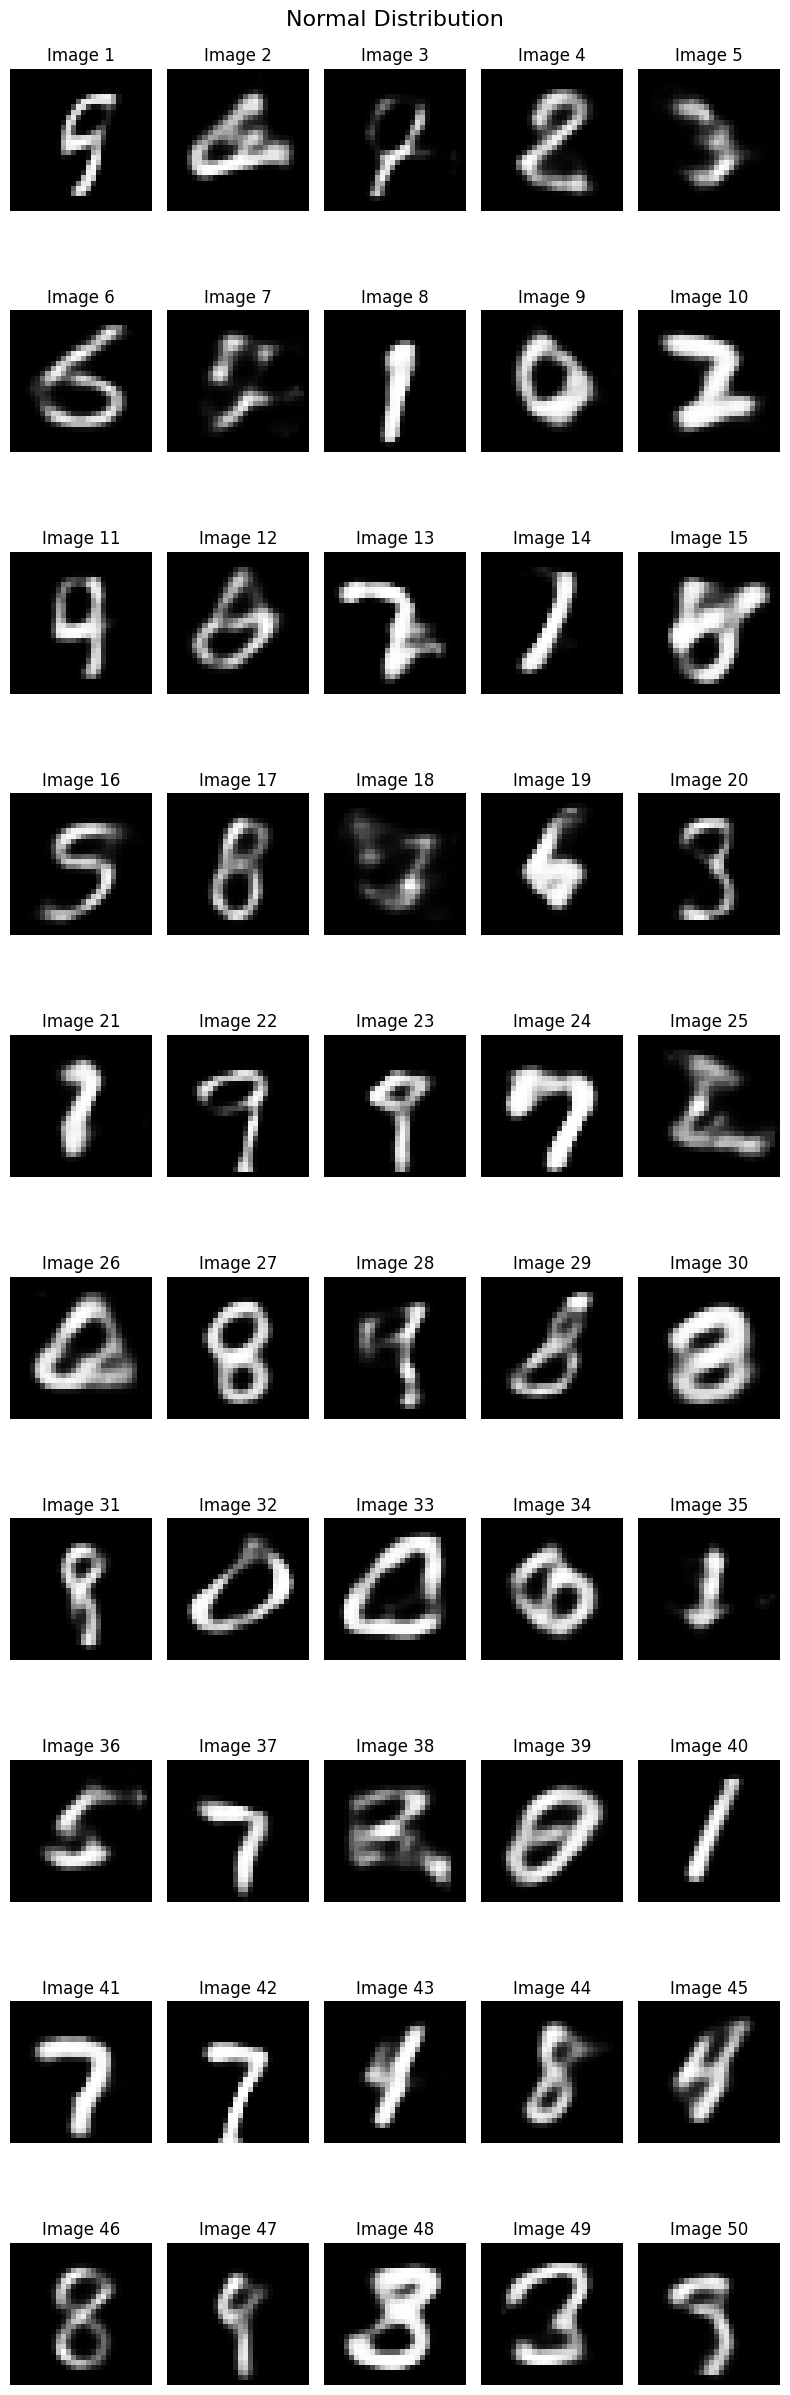

In [15]:
# Plot the generated digits
plt.figure(figsize=(8, 25))  # Adjust the figure size as needed

for i in range(num_images_gen):
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns (50 images in total)
    plt.imshow(digit_normal[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.suptitle('Normal Distribution', fontsize=16)  # Add the heading
plt.tight_layout()
plt.show()

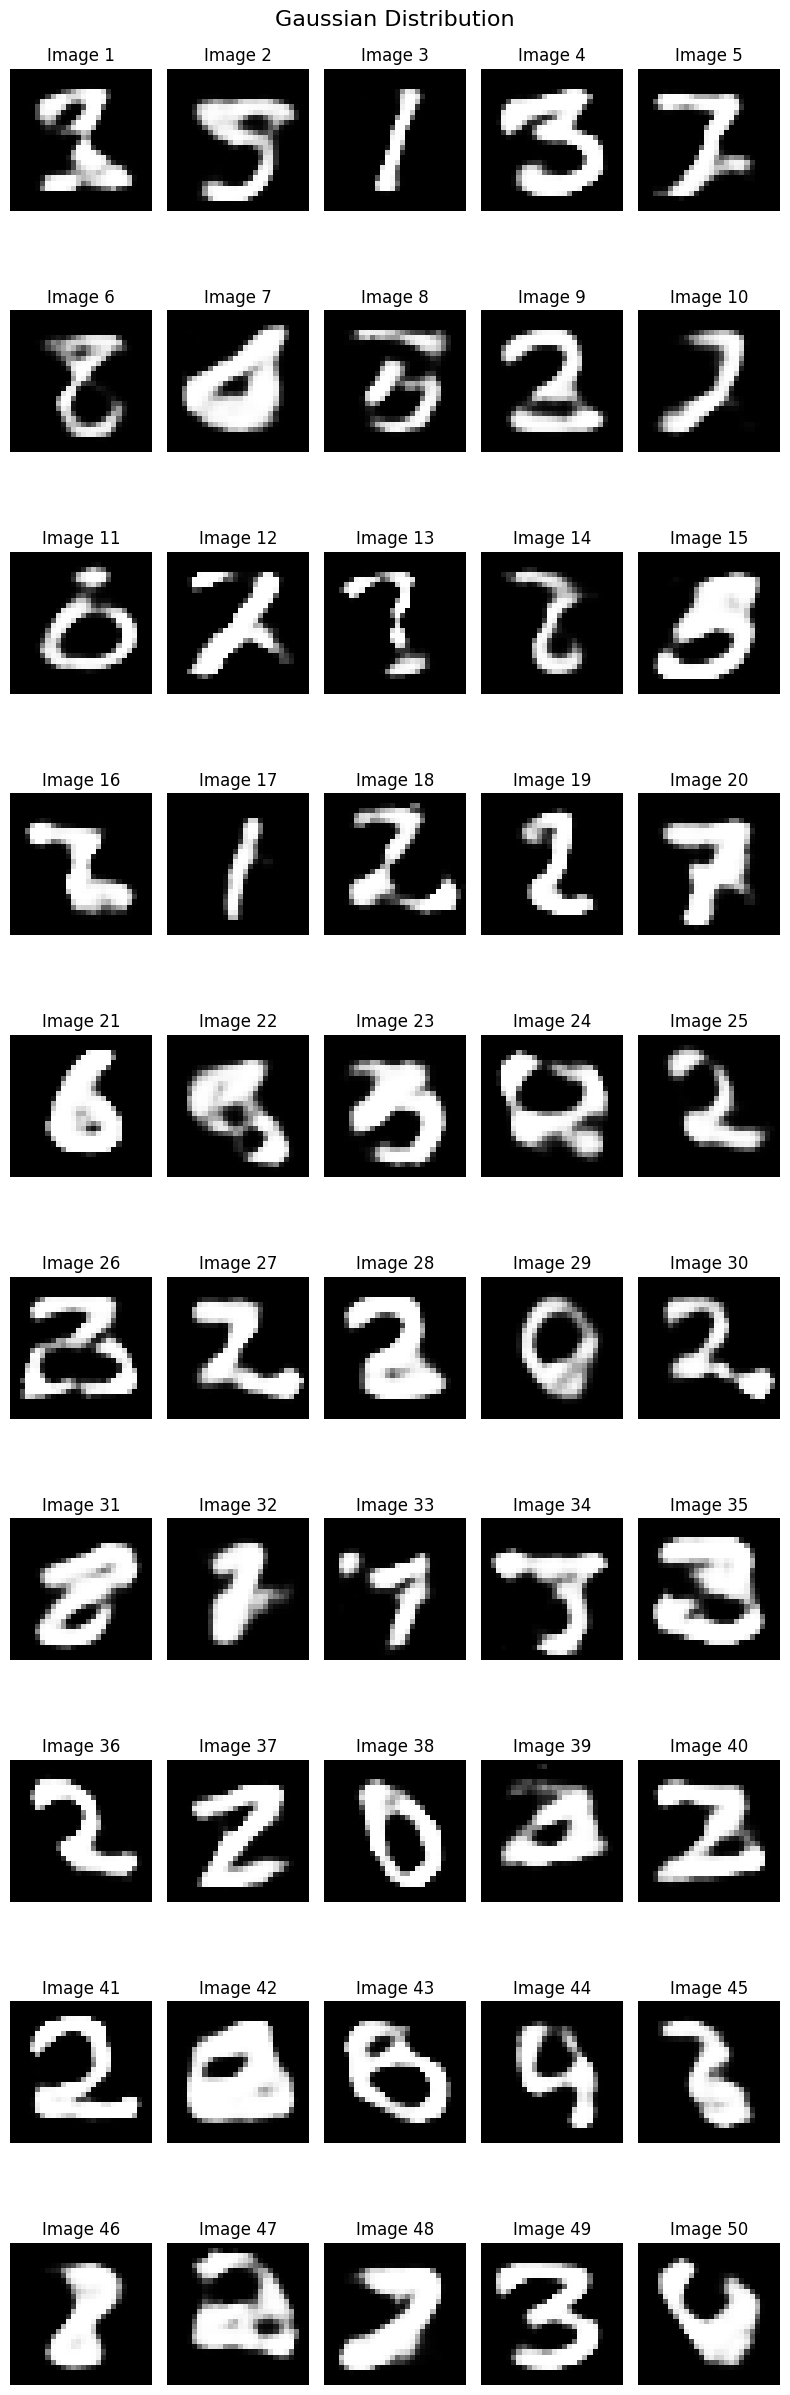

In [17]:
# Plot the generated digits
plt.figure(figsize=(8, 25))  # Adjust the figure size as needed

for i in range(num_images_gen):
    plt.subplot(10, 5, i + 1)  # 10 rows, 5 columns (50 images in total)
    plt.imshow(digit_gaussian[i], cmap='gray')
    plt.title(f'Image {i + 1}')
    plt.axis('off')

plt.suptitle('Gaussian Distribution', fontsize=16)  # Add the heading
plt.tight_layout()
plt.show()